In [42]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import numpy.ma as ma
import joblib 
from time import time
%matplotlib inline
plt.style.use('bmh')
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding as LLE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from matplotlib import offsetbox

In [2]:
# Loading training data
X_train = np.load('data_train.npy').T
t_train = np.load('labels_train_corrected.npy')

print(X_train.shape, t_train.shape)

(6720, 90000) (6720,)


In [3]:
# Inverting colors from black characters on white background --> white characters on black background
data = []
for i in range(len(X_train)):
        X_train[i] = 255 - X_train[i]

# Resizing samples from 300x300 to 30x30 array by taking average of each 10x10 block of pixels
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

data = []
for i in range(len(X_train)):
    data.append(np.ravel(np.array(rebin(X_train[i].reshape(300,300), (30,30)))))
X_train = np.array(data)

Function found on https://stackoverflow.com/questions/8090229/resize-with-averaging-or-rebin-a-numpy-2d-array

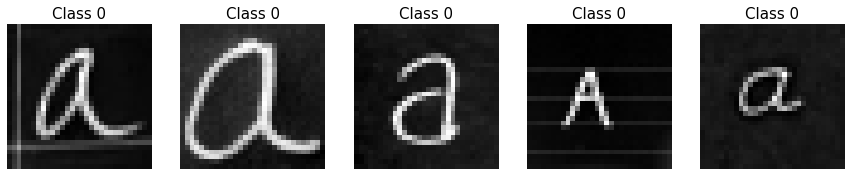

In [4]:
# Displaying some random examples per class
for i in range(1):
    rnd_sample = npr.permutation(np.where(t_train==i)[0])
    fig=plt.figure(figsize=(15,15))
    for j in range(5):
        fig.add_subplot(1,5,j+1)
        plt.imshow(X_train[rnd_sample[j],:].reshape((30,30)),cmap='gray')
        plt.axis('off');plt.title('Class '+str(int(t_train[rnd_sample[j]])),size=15)
    plt.show()

Successfully downsampled and inverted ^^^

In [5]:
print(X_train.shape, t_train.shape)

(6720, 900) (6720,)


In [6]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
joblib.dump(scaler, 'scaler.pkl');

I chose to use standardization because we will be using PCA.

In [7]:
# Implement RFE with Logistic Regression classifier to select a subset of the feature space
lr = LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto', random_state=0)
rfe = RFE(estimator=lr, n_features_to_select=100, step=25, verbose=1)

In [8]:
# Train model with training data
rfe.fit(X_train_scaled, t_train)
joblib.dump(rfe, 'RFE_LogReg_n100_step25.pkl') 
rfe = joblib.load("RFE_LogReg_n100_step25.pkl")

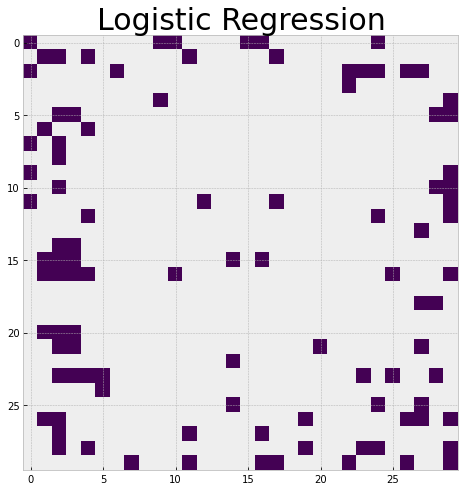

In [33]:
# Identify selected pixels
plt.figure(figsize=(8,8))
plt.imshow(np.reshape(ma.masked_greater(rfe.ranking_, 1), (30,30)))
plt.title('Logistic Regression',size=30)
plt.show()

Purple represents the 100 pixels of the 30x30 image kept by RFE with Logistic Regression Classifier.

This doesn't appear to be a good representation of which pixels are most useful

In [10]:
# Implement RFE with Decision Tree Classifier to select a subset of the feature space
DecisionTree = DecisionTreeClassifier()
rfe2 = RFE(estimator=DecisionTree, n_features_to_select=100, step=25, verbose=1)

In [11]:
# Train model with training data
rfe2.fit(X_train_scaled, t_train)
joblib.dump(rfe2, 'RFE2_DecisionTree_n100_step25.pkl') 
rfe2 = joblib.load("RFE2_DecisionTree_n100_step25.pkl")

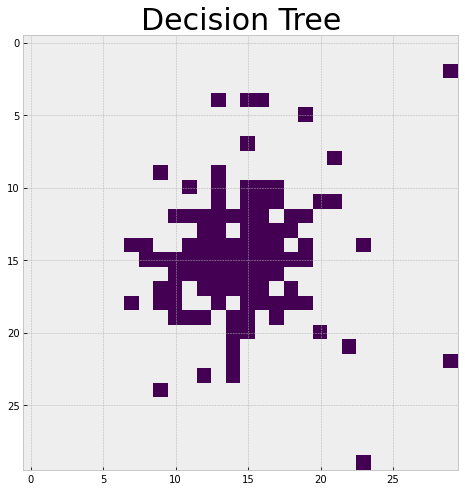

In [32]:
# Identify selected pixels
plt.figure(figsize=(8,8))
plt.imshow(np.reshape(ma.masked_greater(rfe2.ranking_, 1), (30,30)))
plt.title('Decision Tree',size=30)
plt.show()

Purple represents the 100 pixels of the 30x30 image kept by RFE with Decision Tree Classifier.

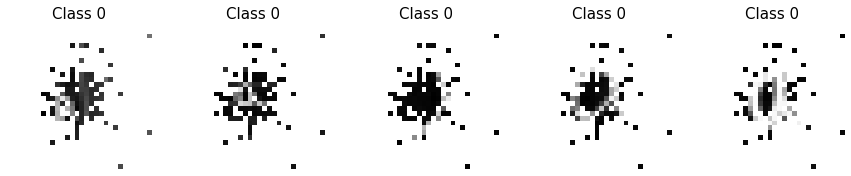

In [13]:
# Mask examples from the training set
for i in range(1):
    rnd_sample = npr.permutation(np.where(t_train==i)[0])
    fig=plt.figure(figsize=(15,15))
    for j in range(5):
        fig.add_subplot(1,5,j+1)
        plt.imshow((X_train[rnd_sample[j],:] * ma.masked_greater(rfe2.ranking_, 1)).reshape((30,30)),cmap='gray')
        plt.axis('off');plt.title('Class '+str(int(t_train[rnd_sample[j]])),size=15)
    plt.show()

In [35]:
# Train PCA object with training data
pca = PCA(n_components=900)
pca.fit(X_train_scaled)

PCA(n_components=900)

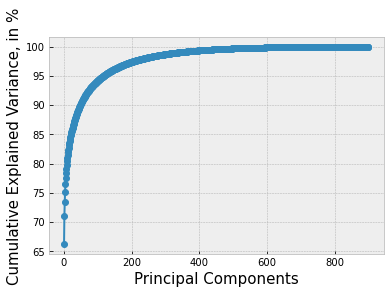

In [36]:
plt.plot(100*np.cumsum(pca.explained_variance_ratio_), '-o')
plt.xlabel('Principal Components',size=15)
plt.ylabel('Cumulative Explained Variance, in %', size=15);

In [15]:
# Identify number of components for 90% explained variance
np.where(np.cumsum(pca.explained_variance_ratio_)>=0.9)[0][0]

48

In the original dataset, we need 49 components to explain at least 90% of the explained variance.

In [16]:
# Train PCA object with number of components for 90% explained variance
pca = PCA(n_components=49)
pca.fit(X_train_scaled)
joblib.dump(pca, 'trained_pca.pkl') 
pca = joblib.load("trained_pca.pkl")

In [17]:
# Reduce dimensionality in training set with trained PCA object
y_train_pca = pca.transform(X_train_scaled)
y_train_pca.shape

(6720, 49)

In [18]:
# Compare classification for original dataset and reduced dataset
t0 = time()
DecisionTree_original_dataset = DecisionTreeClassifier()
DecisionTree_original_dataset.fit(X_train_scaled, t_train)
joblib.dump(DecisionTree_original_dataset, "DT_original_dataset.pkl")
t1 = time()
print("Decision Tree Classifier with original dataset: %.2g sec" % (t1 - t0))
t0 = time()
DecisionTree_reduced_dataset = DecisionTreeClassifier()
DecisionTree_reduced_dataset.fit(y_train_pca, t_train)
joblib.dump(DecisionTree_reduced_dataset, "DT_reduced_dataset.pkl")
t1 = time()
print("Decision Tree Classifier with original dataset: %.2g sec" % (t1 - t0))

Decision Tree Classifier with original dataset: 7.5 sec
Decision Tree Classifier with original dataset: 0.4 sec


In [19]:
7.5/0.4

18.75

Training the classifier with the reduced dataset is about 19 times faster than training the classifier with the original dataset.

In [20]:
# Compare performance
y_train_original_dataset = DecisionTree_original_dataset.predict(X_train_scaled)
ypca = pca.fit_transform(X_train_scaled)
y_train_reduced_dataset = DecisionTree_reduced_dataset.predict(ypca)
print('\nPerformance Report: ')
print(classification_report(t_train, y_train_original_dataset))
print('\nPerformance Report: ')
print(classification_report(t_train, y_train_reduced_dataset))


Performance Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       686
         1.0       1.00      1.00      1.00       680
         2.0       1.00      1.00      1.00       680
         3.0       1.00      1.00      1.00       658
         4.0       1.00      1.00      1.00       656
         5.0       1.00      1.00      1.00       664
         6.0       1.00      1.00      1.00       671
         7.0       1.00      1.00      1.00       680
         8.0       1.00      1.00      1.00       672
         9.0       1.00      1.00      1.00       673

    accuracy                           1.00      6720
   macro avg       1.00      1.00      1.00      6720
weighted avg       1.00      1.00      1.00      6720


Performance Report: 
              precision    recall  f1-score   support

         0.0       0.92      0.93      0.92       686
         1.0       0.89      0.90      0.90       680
         2.0       0.90      0.92 

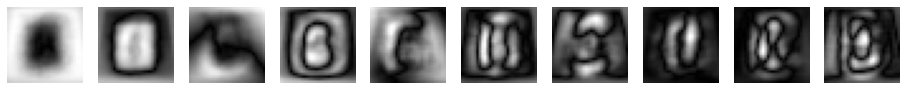

In [21]:
# Display the first 10 eigenvectors from PCA
fig=plt.figure(figsize=(16,4))
for i in range(10): # hard code to 10
    fig.add_subplot(1, 10,i+1)
    plt.imshow(abs(pca.components_[i,:].reshape(30,30)),cmap='gray')
    plt.axis('off')

In [22]:
# Reconstruct images using PCA projections
X_reconstruct_skl = pca.inverse_transform(ypca)
X_reconstruct_skl.shape
X_reconstructed = scaler.inverse_transform(X_reconstruct_skl)
X_reconstructed_skl = scaler.inverse_transform(X_reconstruct_skl)

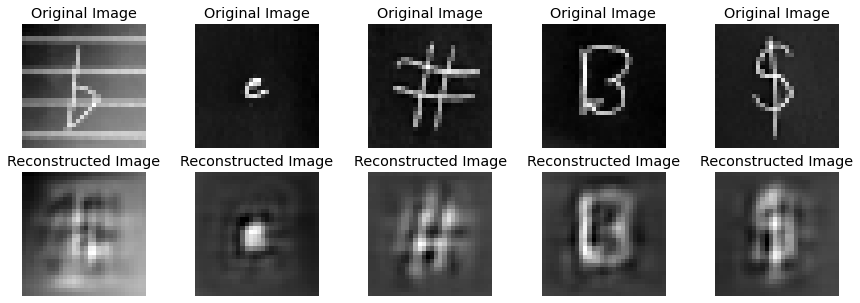

In [23]:
N = 5
j = 1
idx = np.random.choice(range(X_reconstructed.shape[0]),replace=False,size=N)
fig = plt.figure(figsize=(15,5))
for i in range(N):
    fig.add_subplot(2,N,j)
    plt.imshow(X_train[idx[i],:].reshape(30,30), cmap='gray')
    plt.axis('off')
    plt.title('Original Image');

    fig.add_subplot(2,N,j+N)
    plt.imshow(X_reconstructed[idx[i],:].reshape(30,30), cmap='gray')
    plt.axis('off')
    plt.title('Reconstructed Image');
    j+=1

In [25]:
# Tune hyperparameters to find optimal number of dimensions for 3 manifold learning algorithms
pipe = Pipeline([("reduce_dim", "passthrough"),
                 ("clf", DecisionTreeClassifier(random_state=0))])
param_grid = [{"reduce_dim": [TSNE(), Isomap(), LLE()],
               "reduce_dim__n_components": [2, 4, 8]}]
grid_search = GridSearchCV(pipe, n_jobs=1, param_grid=param_grid)
#grid_search.fit(X_train_scaled, t_train)
joblib.dump(grid_search.best_estimator_, 'final_model.pkl') 
grid_search = joblib.load("final_model.pkl")

In [26]:
grid_search.best_params_, grid_search.best_score_

({'reduce_dim': Isomap(n_components=8), 'reduce_dim__n_components': 8},
 0.1517857142857143)

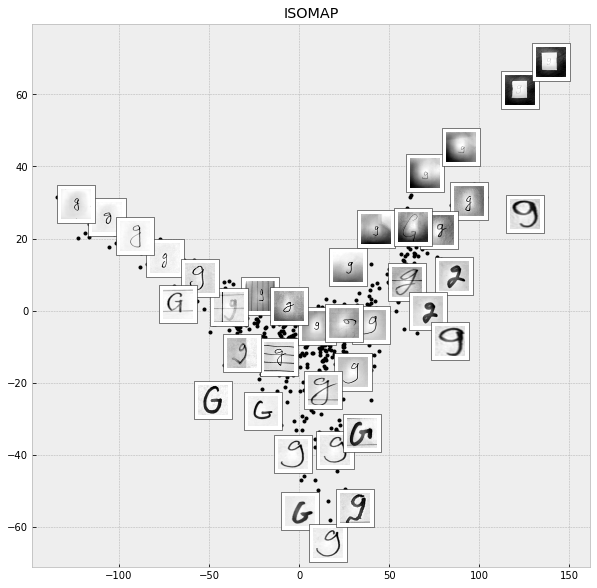

In [27]:
# Display samples in first 2 dimensions of final manifold learning algorithm
def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)
            
images = X_train_scaled 
labels = t_train
X = images.flatten().reshape(6720, 900)
data = X[::]
target = labels[::]            
digit = 6
X = images.flatten().reshape(6720, 900)
data = X[labels == digit,:][::]
fig, ax = plt.subplots(figsize=(10, 10))
# change here if different dataset
model3 = Isomap(n_components=2)
plot_components(data, model3, images=data.reshape((-1, 30, 30)), ax=ax, thumb_frac=0.05, cmap='gray_r')
plt.title('ISOMAP');

The dimension along the horizontal axis appears to roughly correspond to character size and thickness.

The dimension along the vertical axis appears to roughly correspond to the darkness and photo contrast.

In [28]:
# Train final model with training data
final_model = grid_search.best_estimator_
final_model.fit(X_train_scaled, t_train)
y_train_mla = final_model.predict(X_train_scaled)